# Import tabular data

The tabular data is imported. This contains information on whether several elements are present in the image, such as blur, a human, a group, etc. Also the pawpularity score of the training data is in the table. For the test data only the image ID and the features are in the table. There is also a sample submission table, which contains the pawpularity score for the test data.

In [1]:
import pandas as pd

# import the CSV tables
csv_train_data = pd.read_csv("petfinder-pawpularity-score/train.csv")
csv_test_data = pd.read_csv("petfinder-pawpularity-score/test.csv")
sample_submission = pd.read_csv("petfinder-pawpularity-score/sample_submission.csv")
csv_train_data.head()

# Drop rows with missing values (if NaN values are in dataframe)
csv_train_data.dropna()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,ffbfa0383c34dc513c95560d6e1fdb57,0,0,0,1,0,0,0,0,0,0,0,1,15
9908,ffcc8532d76436fc79e50eb2e5238e45,0,1,1,1,0,0,0,0,0,0,0,0,70
9909,ffdf2e8673a1da6fb80342fa3b119a20,0,1,1,1,0,0,0,0,1,1,0,0,20
9910,fff19e2ce11718548fa1c5d039a5192a,0,1,1,1,0,0,0,0,1,0,0,0,20


# Processing tabular data

In [2]:
# Select x-values (the 12 input features) from training data
x_train_tabular = csv_train_data.iloc[:,1:13].to_numpy()

# Select y-values (pawpularity) from training data
y_train_tabular = csv_train_data.iloc[:,13].to_numpy()

# Select x-values (12 input features) from testing data
x_test_tabular = csv_test_data.iloc[:,1:13].to_numpy()

# Select y-values (pawpularity) from testing data
y_test_tabular = sample_submission.iloc[:,1].to_numpy()

In [3]:
from tensorflow.keras import layers, models
from tensorflow.keras.losses import MeanSquaredError

def build_neural_net(input_size, hidden_nodes):
    """
    Build neural network with an input size and a hidden layer with a number of hidden nodes.
    """
    # Create a sequential model object
    model = models.Sequential()

    # Create the hidden layer with sigmoid activations
    model.add(layers.Dense(units=hidden_nodes, activation='relu', input_shape=(input_size,)))
    
    # Create the output layer with 1 regression output unit
    model.add(layers.Dense(units=1))
    
    # Compile the network with the appropriate loss function
    model.compile(loss=MeanSquaredError())
    
    return model

# Create neural network for tabular data and get summary of model
tabular_NN = build_neural_net(12, 20)
tabular_NN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                260       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 281
Trainable params: 281
Non-trainable params: 0
_________________________________________________________________


Train on 8920 samples, validate on 992 samples
Epoch 1/20
8920/8920 [==============================] - 2s 187us/sample - loss: 1340.4031 - val_loss: 731.4031
Epoch 2/20
8920/8920 [==============================] - 1s 101us/sample - loss: 530.1344 - val_loss: 470.5595
Epoch 3/20
8920/8920 [==============================] - 1s 96us/sample - loss: 470.5379 - val_loss: 455.7058
Epoch 4/20
8920/8920 [==============================] - 1s 105us/sample - loss: 461.3362 - val_loss: 447.2280
Epoch 5/20
8920/8920 [==============================] - 1s 102us/sample - loss: 455.4215 - val_loss: 441.5626
Epoch 6/20
8920/8920 [==============================] - 1s 110us/sample - loss: 451.1813 - val_loss: 437.2692
Epoch 7/20
8920/8920 [==============================] - 1s 118us/sample - loss: 447.4371 - val_loss: 433.6421
Epoch 8/20
8920/8920 [==============================] - 1s 121us/sample - loss: 444.1115 - val_loss: 430.5039
Epoch 9/20
8920/8920 [==============================] - 1s 112us/sample -

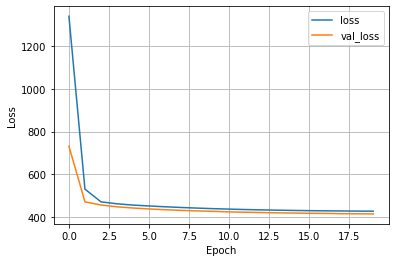

In [4]:
import matplotlib.pyplot as plt

# Part of code from: https://www.tensorflow.org/tutorials/keras/regression

# Train our model
history = tabular_NN.fit(x_train_tabular, y_train_tabular, batch_size=20, epochs=20, validation_split=.1)

# Store loss during training in DataFrame
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

def plot_loss(history):
    """
    Plot loss during epochs of training a neural network.
    """
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

plot_loss(history)

# See how the model scored
loss = tabular_NN.evaluate(x_test_tabular, y_test_tabular)

# Print to 3 decimals
print(f'Test loss: {loss:.3}')

# Import image data


In [5]:
# from os import chdir, listdir
# import matplotlib.pyplot as plt
# import cv2

# # get the training images
# train_imgs = []
# # os.chdir('../petfinder-pawpularity-score/train')
# chdir("C:\\Users\\Cass Maes\\Documents\\PPP\\MinorAI\\ML_project\\CassBenteDemiIlse\\petfinder-pawpularity-score\\train")

# # reshape all the images and store in a list   
# train_img = []
# for i in listdir():
#     file = cv2.imread(i)
#     file=cv2.resize(file,(64,64), interpolation=cv2.INTER_AREA)
#     train_img.append(file/255)
    
# plt.imshow(train_img[0])

In [13]:
from os import chdir, listdir
import matplotlib.pyplot as plt
import cv2

def reshape_images(path, n):
    """
    This function returns a list of images, which are reshaped to 64 x 64 
    and a list with the names of the images.
    """
    
    # set the current path
    chdir(path)
    
    # preset the lists
    images = []
    image_names = []
    
    # go over all the files in the path
    for i in listdir():
        
        # get the name of the image, without .jpg
        image_names.append(i[:-4])
        
        # get the image and reshape to n x n
        file = cv2.imread(i)
        file = cv2.resize(file,(n, n), interpolation=cv2.INTER_AREA)
        
        # rescale the pixels and store in the list
        images.append(file/255)
    
    # change directory back to main directory ("Fitgirls0011")
    chdir("../..")
        
    return images, image_names

train_imgs, train_names = reshape_images("petfinder-pawpularity-score/train", 64)
test_imgs, test_names = reshape_images("petfinder-pawpularity-score/test", 64)

# Combine tabular data with images

In [6]:
def merge_images(data, images, names):
    """
    This function merges the images to the corresponding row of the dataframe.
    """
    
    data['Image'] = ""
    
    # loop over all the names of the images
    for index_image, name_image in enumerate(names):
        
        # loop over all the names in the dataframe
        for index_csv, name_csv in enumerate(data['Id']):
            
            # if the names match, add the image to the row of the dataframe
            if name_image == name_csv:
                data['Image'][index_csv] = images[index_image]

    return data

ERROR! Session/line number was not unique in database. History logging moved to new session 214


In [88]:
merged_train_data = merge_images(csv_train_data, train_imgs, train_names)
merged_test_data = merge_images(csv_test_data, test_imgs, test_names)
display(merged_test_data)


C:\Users\Cass Maes\anaconda3\envs\progLab\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Image
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1,"[[[0.5882352941176471, 0.49019607843137253, 0...."
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0,"[[[0.6823529411764706, 0.5568627450980392, 0.6..."
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1,"[[[0.42745098039215684, 0.5764705882352941, 0...."
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0,"[[[0.27450980392156865, 0.4117647058823529, 0...."
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0,"[[[0.6274509803921569, 0.4235294117647059, 0.2..."
5,b03f7041962238a7c9d6537e22f9b017,0,0,1,1,1,1,1,1,1,0,1,0,"[[[0.5215686274509804, 0.28627450980392155, 0...."
6,c978013571258ed6d4637f6e8cc9d6a3,1,0,0,0,1,1,0,1,0,1,1,1,"[[[0.4392156862745098, 0.3843137254901961, 0.3..."
7,e0de453c1bffc20c22b072b34b54e50f,1,0,1,0,0,0,0,0,1,0,0,1,"[[[0.796078431372549, 0.5529411764705883, 0.39..."


In [85]:
# try_image, try_name = reshape_images("C:\\Users\\Cass Maes\\Documents\\PPP\\MinorAI\\ML_project\\CassBenteDemiIlse\\petfinder-pawpularity-score\\try")
# print(try_name)
# display(try_image)

merge_try_data = merge_images(try_train_data, try_image, try_name)
display(merge_try_data)

C:\Users\Cass Maes\anaconda3\envs\progLab\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Cass Maes\anaconda3\envs\progLab\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0
True
1
2
0
1
True
2
0
1
2
True


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,Image
26,00a1ae8867e0bb89f061679e1cf29e80,0,1,1,0,0,0,1,0,0,0,0,0,52,"[[[0.12549019607843137, 0.1411764705882353, 0...."
27,00a1e0c0f89ff89a8f32d42e9025f6b2,0,1,1,1,0,0,0,0,0,0,0,0,40,"[[[0.7764705882352941, 0.8549019607843137, 0.8..."
28,00a6d367daed96f77be6c91db493dfed,0,1,1,0,0,0,0,0,0,0,0,0,29,"[[[0.30980392156862746, 0.4, 0.486274509803921..."


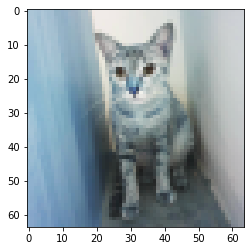

In [90]:
plt.imshow(train_img[10])